# Loading fMRI Data Files into Python 
**V.0.1 - Alpha testing, [Contributions](#contributions)** 

For this script we will use a localizer dataset from [Kim et al. (2017)](https://doi.org/10.1523/JNEUROSCI.3272-16.2017). This dataset will heretofore be referred to as the "VDC" dataset. For the localizer, subjects were shown blocks of faces, scenes and objects in 3 separate runs.

### Goal of this script
Using this script you will learn to visualize your data. Specifically, you will learn the following:
 1. load the fMRI data into python
 2. plot a timeseries for a voxel
 3. Z-score the data -- an important normalization step for machine learning 
 4. use Bokeh, a package for plotting, that will help you explore your data

General fMRI preprocessing, such as motion correction and temporal detrending, is also important, but has already been applied to these data. If you would like to learn more about fMRI preprocessing, you can find some useful lecture material here: https://fsl.fmrib.ox.ac.uk/fslcourse/ (scroll down to 'Lecture slides & Practical Data'). 

## Table of Contents
[1. Import necessary packages](#import)  

[2. Load in timing files](#load_timing)  
>[2.1 Timing file description](#load_timing_describe)  
>[2.2 Plot stimulus presentation](#plot)  

[3. Load fMRI](#load_fmri)  
>[3.1 Plot voxel time series](#plot_voxel)  

[4. Preprocessing](#zscore)  
>[4.1 Check the z scoring](#zscore_check)  

Exercises
>[Exercise 1](#ex1)  
>[Exercise 2](#ex2)  
>[Exercise 3](#ex3)  
>[Exercise 4](#ex4)  
>[Exercise 5](#ex5)  
>[Exercise 6](#ex6)  
>[Exercise 7](#ex7)  
>[Exercise 8](#ex8)  
>[Exercise 9](#ex9)
>[Exercise 10](#ex10)  

>[Novel contribution](#novel)  

## 1. Import necessary packages <a id="import"></a> 
The following packages will be used:  
>nibabel: Read  fMRI data into python arrays.  
>numpy: Perform numerical operations in python. 
>scipy: Scientific computing methods.  
>nilearn: Used to extract masked fMRI data from a Nifti file.
>sklearn: Machine Learning methods.  
>bokeh: Plotting library.  

In [1]:
import warnings
import sys 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
import numpy as np
import nibabel as nib
from nilearn.input_data import NiftiMasker,  MultiNiftiMasker
from scipy import stats
from sklearn import preprocessing
import matplotlib.pyplot as plt 
import seaborn as sns 

# load some helper functions
from qutils import load_vdc_stim_labels, load_vdc_mask, load_vdc_epi_data
# load some constants
from qutils import vdc_data_dir, vdc_all_ROIs, vdc_label_dict, vdc_n_runs

%matplotlib inline 
%autosave 5
sns.set(style = 'white', context='poster', rc={"lines.linewidth": 2.5})

print('data dir = %s' % (vdc_data_dir))
print('ROIs = %s' % (vdc_all_ROIs))
print('Labels = %s' % (vdc_label_dict))
print('number of runs = %d' % (vdc_n_runs))

Autosaving every 5 seconds
data dir = /home/pytorch51/public_FMRI/vdc/
ROIs = ['FFA', 'PPA']
Labels = {1: 'Faces', 2: 'Scenes', 3: 'Objects'}
number of runs = 3


**Exercise 1:**<a id="ex1"></a> Describe the difference in functionality between 'import numpy' and 'from numpy import zeros':



## 2. Load in timing files<a id="load_timing"></a>

The first way we are going to examine this dataset, heretofore referred to as the "vdc" dataset (check the README.md for information on where to find this dataset), is by looking at the timing of events in the experiment. The labels for each run of the experiment are stored in the localizer matlab file (e.g., sub-01_localizer_01.mat). We will read and plot the data that show which stimulus was presented at what time during the experiment. The columns in the data represent time in the experiment.

**Self-study:** Navigate through the folder that contains these data (defined in 'dir' below) to get an understanding of the file structure. Open up the files and look at their contents. Be an explorer!

### 2.1 Timing file description <a id="load_timing_describe"></a>
The localizer consists of 3 runs. Each run contained 15 blocks, with 5 blocks from each of 3 stimulus categories: faces, scenes and objects. There were 10 trials per block. Within a block, a stimulus was presented every 1.5s (1 TR). Between blocks, there were 15s (10 TRs) of fixation. Each run was approximately 310 TRs. 

There is a bunch of information about each run in the matlab stimulus file that we just loaded. Each row contains a different type of information (e.g., stimulus type, reaction time, etc.) and each column represents a different trial. 

When analyzing data it is important to keep checking whether the code you wrote actually does what you intend it to do. For example, if you would have wrote the code in the cell above, one possible thing to check is whether the created output variable stim_label_allruns indeed contains the expected number of rows and columns. You can use a function from the imported numpy package for this purpose: np.shape(stim_label_allruns). Of course, there are plenty of other ways to check whether your code works the way you want it to work.

Of most importance to us, the first row has the stimulus labels for the localizer runs; whereas the third row contains the time in seconds when the stimulus was presented (relative to the start of each run). The data were loaded in such that the three runs were concatenated in time.

The stimulus labels used in row 1 and their corresponding categories are as follows:  
1= Faces  
2= Scenes  
3= Objects  

In [2]:
# Make sure you edit the following line to reflect the directory where you are accessing the VDC dataset
sub = 'sub-01'
stim_label_allruns = load_vdc_stim_labels(sub)
print('stim_label_allruns has shape: ', np.shape(stim_label_allruns))

# Because Python suppresses output (when there is no error), you may want to include print statements at the end of 
# cells to indicate to you when a cell has executed all lines of code

stim_label_allruns has shape:  (10, 450)


**Exercise 2:**<a id="ex2"></a> How big is the dataset in terms of number of subjects and number of training examples?



### 2.2 Plot stimulus presentation <a id="plot_timing"></a>

Of course, you can look at the timeline of the stimulus presentation by selecting these rows and output them as an array of values (stim_label_allruns[0,:] and stim_label_allruns[2,:]). However, a better way of visualizing the timeline of the stimulus presentation is by creating a plot, which we will now teach you by using the plotting package matplotlib (that you have imported earlier in this script).

**Self-study:** Don't know what a python dictionary is? Look it up!


In [3]:
# choose a run 
run_id = 2

# select the corresponding time points for a given run
time_points_mask = stim_label_allruns[5,:] == run_id

# the 1st row is the labels of the stimuli 
labels = stim_label_allruns[0, time_points_mask]
# the 2nd row is time in secs 
time_secs = stim_label_allruns[2, time_points_mask]

print('labels:\n\n %s \n\n' % labels)
print('time_secs:\n\n%s' % time_secs)

labels:

 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 3. 3. 3.
 3. 3. 3. 3. 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3.
 3. 3. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2.
 2. 2. 2. 2. 3. 3. 3. 3. 3. 3. 3. 3. 3. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 2. 2. 2. 2.
 2. 2. 2. 2. 2. 2.] 


time_secs:

[ 12.   13.5  15.   16.5  18.   19.5  21.   22.5  24.   25.5  42.   43.5
  45.   46.5  48.   49.5  51.   52.5  54.   55.5  72.   73.5  75.   76.5
  78.   79.5  81.   82.5  84.   85.5 102.  103.5 105.  106.5 108.  109.5
 111.  112.5 114.  115.5 132.  133.5 135.  136.5 138.  139.5 141.  142.5
 144.  145.5 162.  163.5 165.  166.5 168.  169.5 171.  172.5 174.  175.5
 192.  193.5 195.  196.5 198.  199.5 201.  202.5 204.  205.5 222.  223.5
 225.  226.5 228.  229.5 231.  232.5 234.  235.5 252.  253.5 255.  256.5
 258. 

#### Here's the minimal structure of a matplotlib plot

Text(0.5,0,'time in secs')

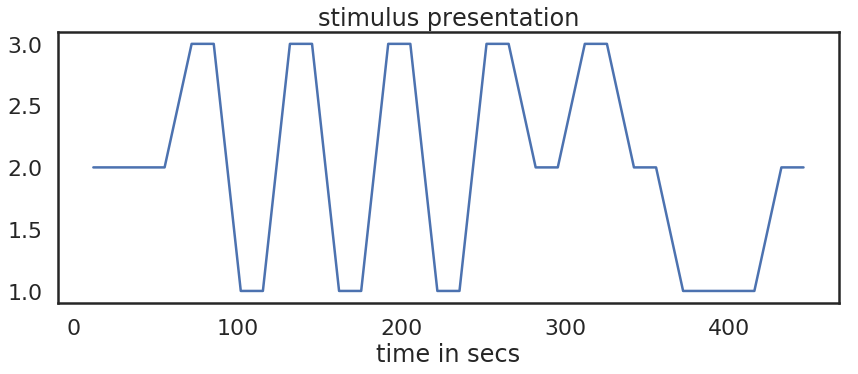

In [4]:
# create a 1 x 1 figure panel 
n_rows = 1
n_cols = 1
f, ax = plt.subplots(n_rows, n_cols, figsize = (14, 5))

# then ax.plot(x, y) will create a line plot 
ax.plot(time_secs, labels)

# you can add plot title like this
ax.set_title('stimulus presentation')

# you can set xlabel like this
ax.set_xlabel('time in secs')

#### Can you explain what the plot is visualizing? 
#### The plot above is not very informative, let's add some stuff... 

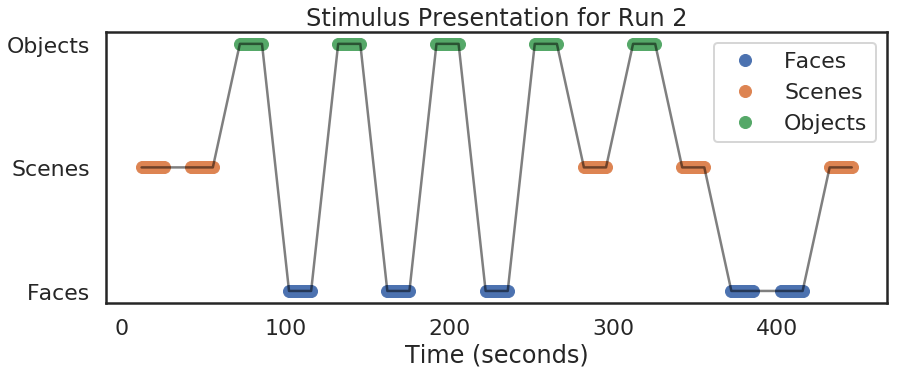

In [5]:
# this command creates a panel 
f, ax = plt.subplots(1,1, figsize = (14, 5))

# plot the stimuli as points
for label in list(vdc_label_dict.keys()): 
    temp_mask = label == labels
    ax.plot(time_secs[temp_mask], labels[temp_mask], 'o')
# plot the stimuli as a line 
ax.plot(time_secs, labels, color = 'black', alpha = .5)

ax.set_title('Stimulus Presentation for Run %d' % (run_id))
ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())
ax.set_xlabel('Time (seconds)')
ax.legend(vdc_label_dict.values())

**Exercise 4:**<a id="ex4"></a> Plot the stimulus presentation for runs 2 and 3 for this subject.

**Exercise 5:**<a id="ex5"></a> How many stimuli were presented in each block?

**Exercise 6:**<a id="ex6"></a> Is the stimulus presented in the same order for all the three runs?

Text(0.5,0,'Time points')

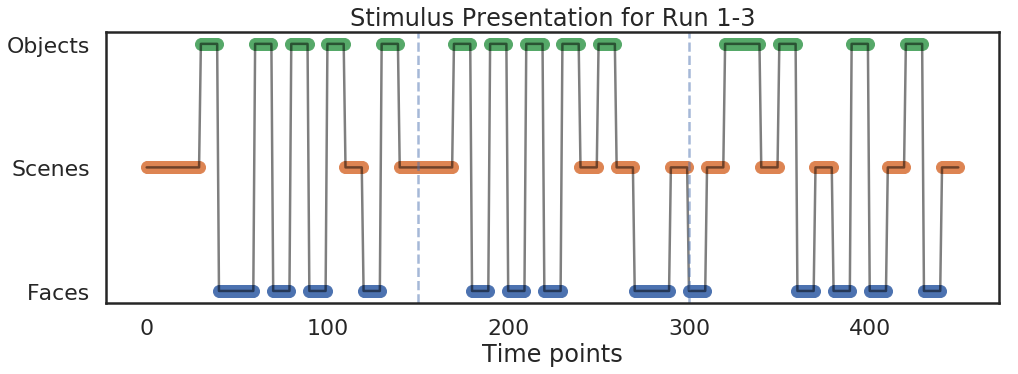

In [6]:
"""solution 1: plot 3 runs together"""

f, ax = plt.subplots(1, 1, figsize = (16, 5))

labels = stim_label_allruns[0, :]
time_secs = stim_label_allruns[2, :]
time_pts = np.arange(len(time_secs))

# plot the stimuli as points
for label in list(vdc_label_dict.keys()): 
    temp_mask = label == labels
    ax.plot(time_pts[temp_mask], labels[temp_mask], 'o')
# plot the stimuli as a line 
ax.plot(time_pts, labels, color = 'black', alpha = .5)

ax.axvline(150, alpha = .5, linestyle = '--')
ax.axvline(300, alpha = .5, linestyle = '--')

ax.set_title('Stimulus Presentation for Run 1-3')
ax.set_yticks(list(vdc_label_dict.keys()))
ax.set_yticklabels(vdc_label_dict.values())
ax.set_xlabel('Time points')
# ax.legend(vdc_label_dict.values())

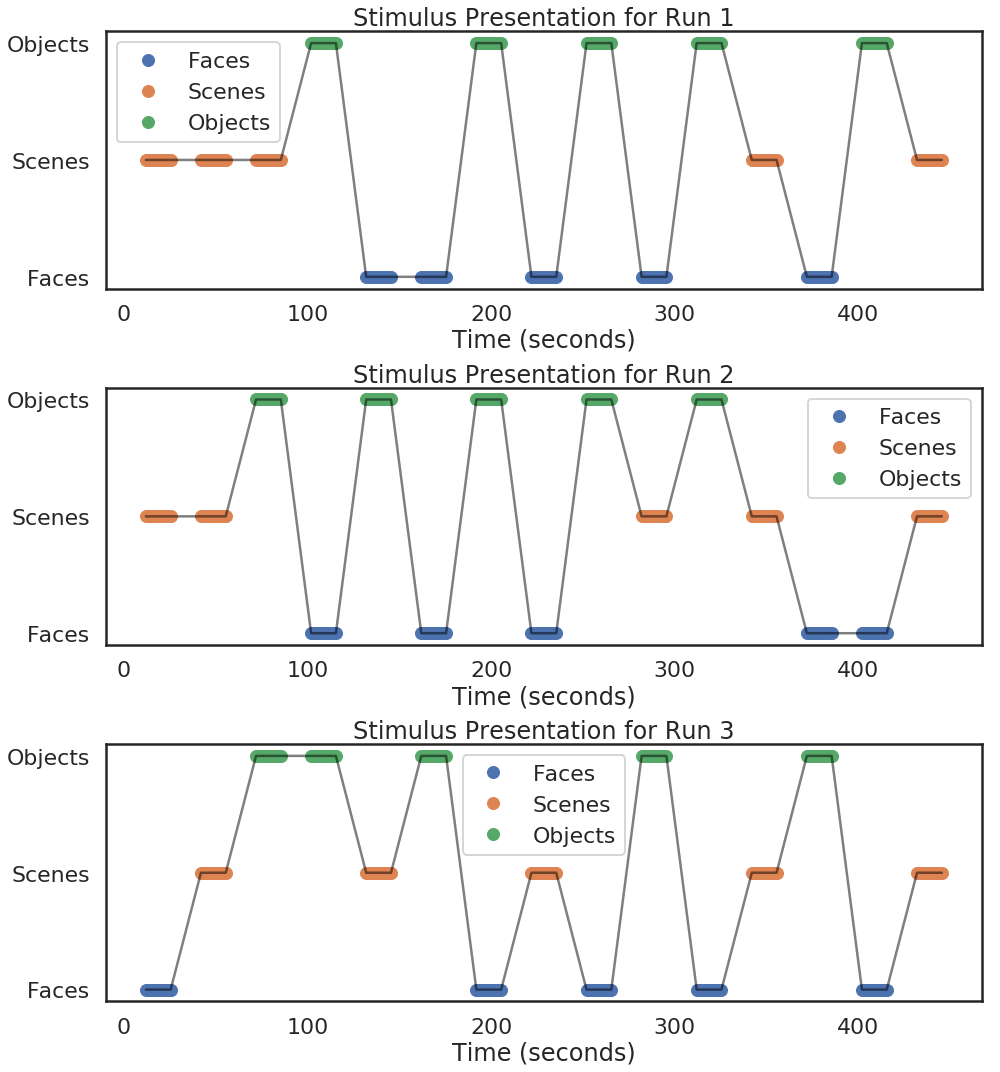

In [7]:
"""solution 2: plot 3 runs separately"""

f, axes = plt.subplots(3, 1, figsize = (14, 15))

for r in range(vdc_n_runs): 
    run_id = r + 1 
    time_points_mask = stim_label_allruns[5,:] == run_id
    labels = stim_label_allruns[0, time_points_mask]
    time_secs = stim_label_allruns[2, time_points_mask]

    # plot the stimuli as points
    for label in list(vdc_label_dict.keys()): 
        temp_mask = label == labels
        axes[r].plot(time_secs[temp_mask], labels[temp_mask], 'o')
    # plot the stimuli as a line 
    axes[r].plot(time_secs, labels, color = 'black', alpha = .5)

    axes[r].set_title('Stimulus Presentation for Run %d' % (run_id))
    axes[r].set_yticks(list(vdc_label_dict.keys()))
    axes[r].set_yticklabels(vdc_label_dict.values())
    axes[r].set_xlabel('Time (seconds)')
    axes[r].legend(vdc_label_dict.values())

f.tight_layout()    

## 3. Load fMRI data <a id="load_fmri"></a>

We'll load the data for one run. We will also extract a subset of the signal from the whole-brain data by using a mask for the "fusiform face area" ('FFA').

In [8]:
print('Here\'re the avaliable ROIs: ', vdc_all_ROIs)

Here're the avaliable ROIs:  ['FFA', 'PPA']


#### Get voxels from an ROI

The following code will ... 
1. load whole brain fMRI data (for a given subject and a givern run)
2. load the mask of FFA 
3. use `NiftiMasker` to sub-select FFA voxels from the whole brain data
    - `NiftiMasker` is a function from nilearn. Here's <a href="https://nilearn.github.io/auto_examples/04_manipulating_images/plot_mask_computation.html">an example</a> about how to use it, and here's the official <a href="https://nilearn.github.io/modules/generated/nilearn.input_data.NiftiMasker.html">documentation</a>. 

In [9]:
# choose FFA
ROI_name = 'FFA'

# 1. Load the fMRI data 
epi_data = load_vdc_epi_data(sub, run_id)
# 2. Load the mask file 
mask = load_vdc_mask(ROI_name, sub)
# 3. Apply ROI mask
nifti_masker = NiftiMasker(mask_img=mask)
maskedData = nifti_masker.fit_transform(epi_data)

# transpose the data to voxel by TR (because sklearn will need this format later)
# maskedData = maskedData.T

print('data shape - before masking: ', epi_data.shape)
print('data shape - after masking: ', maskedData.shape)
print('mask name: ', ROI_name)

data shape - before masking:  (128, 128, 52, 310)
data shape - after masking:  (310, 5519)
mask name:  FFA


**Self-study:** Not quite sure how the process of applying the mask worked in detail? Check out the documentation of the function we used (nilearn.input_data.NiftiMasker).

**Self-study:** What is the parahippocampal place area (PPA)?

**Exercise 7:**<a id="ex7"></a> Make a volume with a PPA mask and create an image to show a slice through this mask.

**Exercise 8:**<a id="ex8"></a> We used nilearn to do the masking in the above code. How else could you mask the fMRI data?

<font color='red'>
    Q: use boolean masks? What's the expected solution here? 
</font>

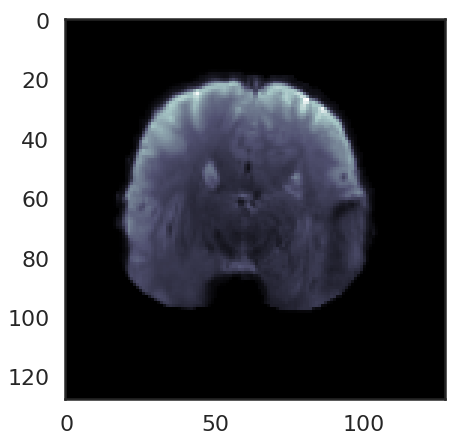

In [13]:
"""solution: ex 7"""

from scipy import ndimage
epi_data_nparray = epi_data.get_data()

# choose a slice of the brain
t = 50
brain_slice = epi_data_nparray[:,:,32, t]
brain_slice = ndimage.interpolation.rotate(brain_slice, angle = -90)

f, ax = plt.subplots(1,1, figsize = (7,7))
ax.imshow(brain_slice, cmap = 'bone')

### 3.1. Plot a voxel time-series <a id="plot_voxel"></a>

After masking, the fMRI dataset at this stage (found in the variable epi_mask_data that was created in the cell above) is in the format rows=time (i.e. 310 rows referring to 310 TRs) and columns=voxels (i.e. the number of voxels in your mask, FFA in this example). First, we'll transpose the data to make the time series go across columns. Each time-point will be a column vector of voxel values. Then we will plot the time-series of one voxel. 

Text(0,0.5,'Voxel Intensity')

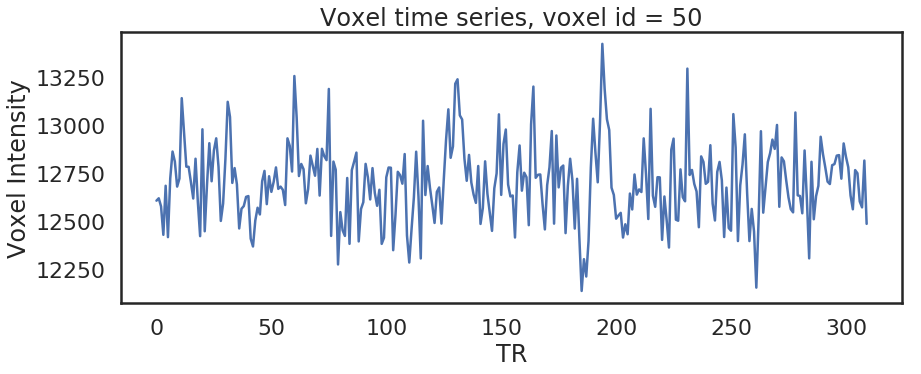

In [14]:
# Plot a voxel value (in this example of voxel 100) through time
time_id = 100
voxel_id = 50

f, ax = plt.subplots(1,1, figsize=(14,5))
ax.plot(maskedData[:, voxel_id])

ax.set_title('Voxel time series, voxel id = %d' % voxel_id)
ax.set_xlabel('TR')
ax.set_ylabel('Voxel Intensity')

## 4. Preprocessing <a id="zscore"></a>

Now we'll scale the data to center the mean around zero and have a standard deviation of one ($\mu=0, \sigma = 1$) for  the data. Why do we scale the data? See here: http://scikit-learn.org/stable/modules/preprocessing.html

There are many ways to scale the data. Z-scoring is one of the most common approaches. We will use the StandardScaler method to accomplish this. 

**Self-study:** Explore other normalization techniques in the link above.

`StandardScaler` is a function from `sklearn.preprocessing`. `sklearn` functions tend to have the following generate useage: 

- step 1: `sklearn_function.fit(some_data)`, which returns as fitted model
- step 2: `sklearn_function.transform(some_data)`, which returns the transformed data 

The following example should make this clear... 

In [15]:
# z score the data 
# the following procedure normalize the response within voxels over time
scaler = preprocessing.StandardScaler().fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)

"""another way
scaler = preprocessing.StandardScaler()
scaler.fit(maskedData)
maskedData_zscore = scaler.transform(maskedData)
"""

"""another way
maskedData_zscore = preprocessing.StandardScaler().fit_transform(maskedData)
"""

'another way\nmaskedData_zscore = preprocessing.StandardScaler().fit_transform(maskedData)\n'

### 4.1 Check the z scoring <a id="zscore_check"></a>

The mean values never equal exactly zero. This happens because of rounding and precision limitations. These small values are considered zero for most practical purposes. We can print out the values. Also check that the standard deviation is now correct.

In [16]:
x_mean = np.mean(maskedData_zscore, axis=0)
x_std = np.std(maskedData_zscore, axis=0)
print('the mean of 1st few time points:\n', x_mean[0:10])
print('the std of 1st few time points:\n', x_std[0:10])
print(np.shape(x_mean))

the mean of 1st few time points:
 [-3.1525018e-05  6.7764713e-06 -6.4478768e-06  1.5474135e-06
 -3.3663166e-06 -2.7051279e-05 -2.7148954e-07 -1.2571292e-05
 -1.9638769e-06  8.9914565e-06]
the std of 1st few time points:
 [1.0000001  0.99999976 1.0000001  1.0000001  0.9999998  1.
 1.         1.0000001  1.0000001  1.        ]
(5519,)


**Exercise 9:**<a id="ex0"></a> compared the raw data vs. the z-scored data

Text(0.5,0,'TR')

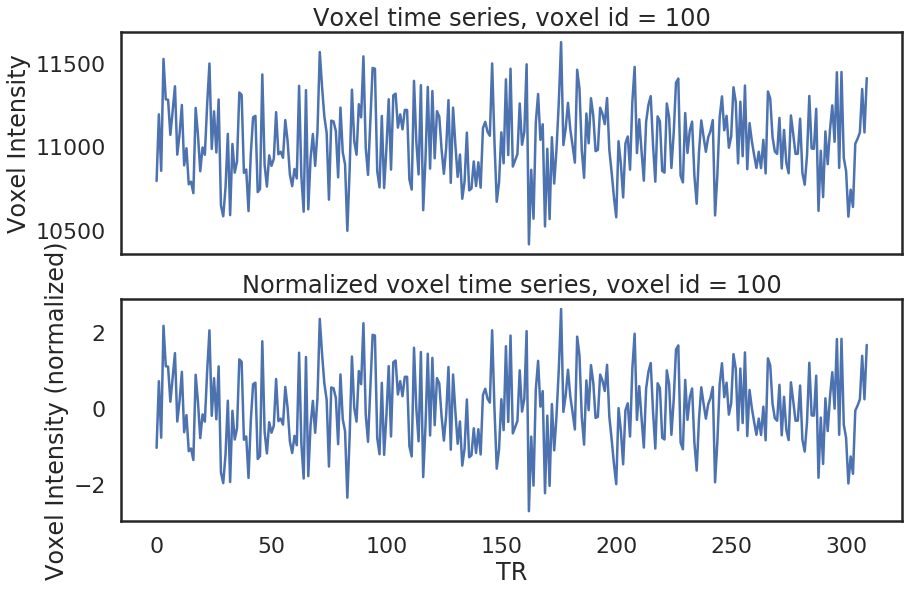

In [17]:
"""example solution"""
"""the general "shape" of the time series is maintained, but the y-axis is rescaled"""

# Plot a voxel value (in this example of voxel 100) through time
voxel_num = 100

f, axes = plt.subplots(2,1, figsize=(14,9), sharex=True)
axes[0].plot(maskedData[:, voxel_num])
axes[1].plot(maskedData_zscore[:, voxel_num])

axes[0].set_title('Voxel time series, voxel id = %d' % voxel_num)
axes[0].set_ylabel('Voxel Intensity')

axes[1].set_title('Normalized voxel time series, voxel id = %d' % voxel_num)
axes[1].set_ylabel('Voxel Intensity (normalized)')
axes[1].set_xlabel('TR')

**Exercise 9:**<a id="ex0"></a> Plot the distribution of values as a histogram.

<font color='red'>
    Q: histogram visualization is a little ugly here... 
</font>

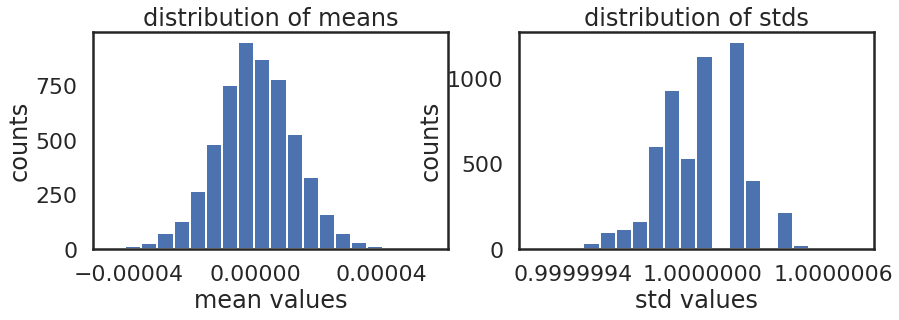

In [18]:
f, axes = plt.subplots(1, 2, figsize = (14,4))

n_bins = 20

axes[0].hist(x_mean, bins = n_bins)
axes[0].set_title('distribution of means')
axes[0].set_xlabel('mean values')
axes[0].set_ylabel('counts')
axes[0].xaxis.set_major_locator(plt.MaxNLocator(3))

axes[1].hist(x_std, bins = n_bins)
axes[1].set_title('distribution of stds')
axes[1].set_xlabel('std values')
axes[1].set_ylabel('counts')
axes[1].xaxis.set_major_locator(plt.MaxNLocator(3))
axes[1].get_xaxis().get_major_formatter().set_useOffset(False)

**Exercise 10:**<a id="ex10"></a> Z-score the data by writing your own code instead of using the StandardScaler() method.


In [19]:
""" example solution """
# Insert your code here

# Compute the mean of the data
vox_means = np.mean(maskedData, axis=0, keepdims=True)
# Compute the standard deviation
vox_stds = np.std(maskedData, axis = 0, keepdims=True)

# Z-score the data
maskedData_normalized = (maskedData - vox_means) / vox_stds

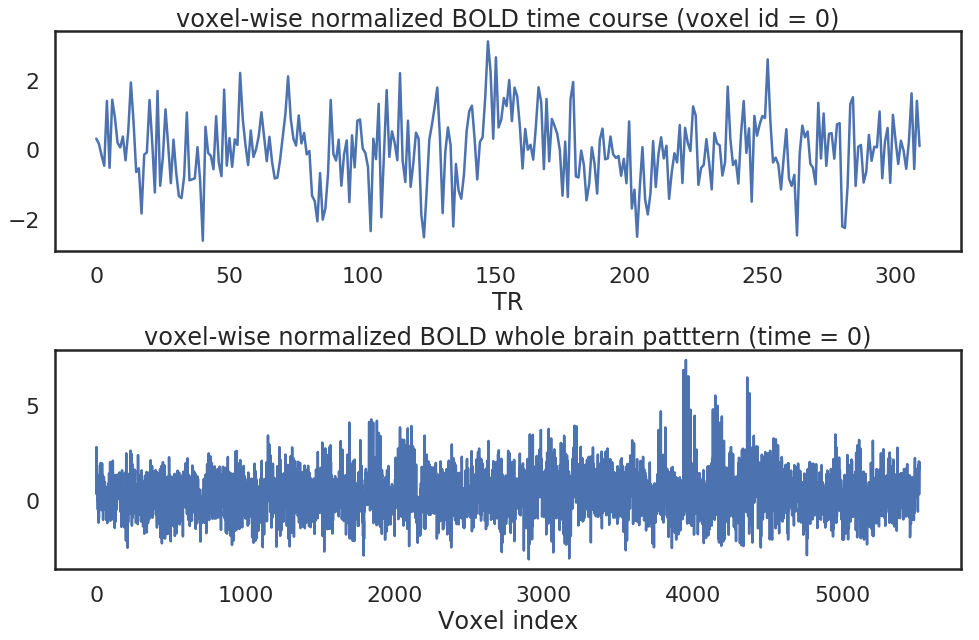

In [20]:
f, axes = plt.subplots(2,1,figsize = (14,9))
v = 0
t = 0 

# Plot the results for the a feature vector at one time-point
axes[0].plot(maskedData_normalized[:, v])
axes[0].set_title('voxel-wise normalized BOLD time course (voxel id = %d)' % (v))
axes[0].set_xlabel('TR')

# Plot the time-series for one voxel
axes[1].plot(maskedData_normalized[t, :])
axes[1].set_title('voxel-wise normalized BOLD whole brain patttern (time = %d)' % (t))
axes[1].set_xlabel('Voxel index')

f.tight_layout()

**Novel contribution:**<a id="novel"></a> Be creative and make one new discovery by adding an analysis, visualization, or optimization.

## Contributions <a id="contributions"></a>

M. Kumar, C. Ellis and N. Turk-Browne produced the initial notebook  
T. Meissner minor edits  
Q. Lu switch to matplotlib, encapsulate helper functions, del ex.3 (loop)